# Image Classification Using CIFAR-10 dataset

The CIFAR-10 (Canadian Institute For Advanced Research) dataset contains 60,000 32x32 color images. Each image is labeled with one of the following 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. There are 50000 training images and 10000 test images. 


# Table of Contents

This assignment has 5 parts. You will practice PyTorch on **three different levels of abstraction**.

1. Part I, Preparation: we will use CIFAR-10 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors. 
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define arbitrary neural network architectures. 
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a linear feed-forward network very conveniently. 
5. Part V, Tuning: Experiment with different architectures, activation functions, weight initializations, optimizers, hyperparameters, regularizations or other advanced features. Your goal is to get accuracy as high as possible on CIFAR-10 (without using convolutional layers).

# Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

First, we load the CIFAR-10 dataset. PyTorch provides convenient tools to download the CIFAR-10 dataset, preprocess it, and iterate through it in minibatches. The downloading might take a couple minutes the first time you do it, but the files should stay cached after that.



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import time
import matplotlib.pyplot as plt


In [3]:
NUM_TRAIN = 49000 #number of examples used to train the models; 1000 examples are used for validation

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; the mean and std are hardcoded
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./DL/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./DL/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./DL/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Extracting ./DL/datasets/cifar-10-python.tar.gz to ./DL/datasets
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Part II. Barebones PyTorch

PyTorch comes with high-level APIs to help us define model architectures conveniently, as we will see in Parts III and IV. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. 

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when using convolutional neural networks (we will explore CNNs in a future assignment). When we use fully connected linear/affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [5]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [12]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [6]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-0.8992, -0.2021,  0.5090,  0.1557,  1.4658],
        [-0.2646,  0.4733,  0.1587, -0.6398,  1.2465],
        [-1.4026, -0.4363,  1.6220, -0.1923, -0.8709]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [ ]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [ ]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

Without any hyperparameter tuning, you should see accuracies above 40% after training for one epoch.

In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.3824
Checking accuracy on the val set
Got 141 / 1000 correct (14.10%)

Iteration 100, loss = 2.5761
Checking accuracy on the val set
Got 328 / 1000 correct (32.80%)

Iteration 200, loss = 2.0554
Checking accuracy on the val set
Got 372 / 1000 correct (37.20%)

Iteration 300, loss = 2.3932
Checking accuracy on the val set
Got 353 / 1000 correct (35.30%)

Iteration 400, loss = 1.8674
Checking accuracy on the val set
Got 418 / 1000 correct (41.80%)

Iteration 500, loss = 1.8383
Checking accuracy on the val set
Got 420 / 1000 correct (42.00%)

Iteration 600, loss = 1.9233
Checking accuracy on the val set
Got 409 / 1000 correct (40.90%)

Iteration 700, loss = 2.1214
Checking accuracy on the val set
Got 430 / 1000 correct (43.00%)



# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as SGD (including SGD with Momentum), RMSProp, and Adam. You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [ ]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in Part II. You don't manually pass in the parameters anymore.

In [7]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [8]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to Part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

Without any hyperparameter tuning, you should see model accuracies above 40% after training for one epoch.

In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Iteration 0, loss = 3.4354
Checking accuracy on validation set
Got 176 / 1000 correct (17.60)

Iteration 100, loss = 2.6307
Checking accuracy on validation set
Got 344 / 1000 correct (34.40)

Iteration 200, loss = 1.8477
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Iteration 300, loss = 2.0045
Checking accuracy on validation set
Got 377 / 1000 correct (37.70)

Iteration 400, loss = 1.5945
Checking accuracy on validation set
Got 415 / 1000 correct (41.50)

Iteration 500, loss = 1.8785
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)

Iteration 600, loss = 1.8374
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Iteration 700, loss = 1.6948
Checking accuracy on validation set
Got 439 / 1000 correct (43.90)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, without any hyperparameter tuning, you shoud achieve above 40% accuracy after one epoch of training.

In [ ]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Iteration 0, loss = 2.3408
Checking accuracy on validation set
Got 157 / 1000 correct (15.70)

Iteration 100, loss = 1.6241
Checking accuracy on validation set
Got 401 / 1000 correct (40.10)

Iteration 200, loss = 1.8077
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Iteration 300, loss = 1.8660
Checking accuracy on validation set
Got 418 / 1000 correct (41.80)

Iteration 400, loss = 1.5652
Checking accuracy on validation set
Got 431 / 1000 correct (43.10)

Iteration 500, loss = 1.8602
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Iteration 600, loss = 1.3936
Checking accuracy on validation set
Got 424 / 1000 correct (42.40)

Iteration 700, loss = 1.5692
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)



# Part V: Tuning

In this section, you are asked to experiment with different dense/fully connnected architectures, activation functions, weight initializations, hyperparameters, optimizers, and regularization approaches to train models on the CIFAR-10 dataset. You can use the check_accuracy and train functions from above. You can use either BareBones PyTorch or the `nn.Module` or `nn.Sequential` API. 

Here is the official API documentation for some of the components you will experiment with. 

* Weight initializations: https://pytorch.org/docs/stable/nn.init.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things to experiment with:
- **Network architectures**: The network above has two layers of trainable parameters. Can you do better with a deeper network? Or maybe with a wider network? Try three different architectures and observe the performance on the validation data. Use the architectures in combinations with other hyperparameters, as outlines below. Discuss your findings.
- **Activation functions**: In your networks, use two different activation functions, such as ReLU, leaky ReLU, parametric ReLU, ELU, MaxOut, or tanh to gain practical insights into their ability to improve accuracy. 
- **Weight initialization**: Corresponding to your activation functions, use different weight initialization schemes. Discuss your findings. What happens if you use the zero_weight initialization? 
- **Batch normalization**: Try adding batch normalization. Do your networks train faster? Does the accuracy improve?
- **Optimizers**: Use two optimizers,  SGD and Adam (you can also try  SGD with momentum, and RMSprop, if you'd like, but it's not required). Use the optimizers with and without batch normalization to observe what optimizers benefit more from batch normalization, or different weight initializations schemes and what optimizers are more robust to initialization/normalization. 
- **Regularization**: Compare two regularization methods from those discussed in the lecture (e.g., L2 weight regularization, with dropout, batch normalization, and data augmentation). Discuss your findings.  

### Tips for training
For each network architecture that you try, you should tune the learning rate (and maybe other hyperparameters). When doing this, there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.


## Describe what you did 

In the cell below you should write an explanation of what you did, any features that you implemented, and/or any graphs that you made in the process of training and evaluating your network. In the process, answer the questions listed in the section on `Things to experiment with'. What is the best accuracy you obtained on the validation data?

# The three simple networks I tried networks I tried

1. less wider
2. Wider 
3. less deeper
4. deeper

# Part 1 : Deeper or wider 

First we test network with changing the 

In [ ]:
torch.manual_seed(0)

In [ ]:
################################################################################
# TODO:                                                                        #         
# Experiment with architectures, activation functions, weight initializations, #
# optimizers,  hyperparameters, and regularization schemes.                    #
# Keep track of the best accuracy on the *validation set* within 10 epochs.    #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 8000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

start_time = time.time()
train_part34(model, optimizer, epochs=10)
print("--- %s seconds ---" % (time.time() - start_time))
print(check_accuracy_part34(loader_test, model))

Iteration 0, loss = 2.3507
Checking accuracy on validation set
Got 135 / 1000 correct (13.50)

Iteration 100, loss = 2.0739
Checking accuracy on validation set
Got 369 / 1000 correct (36.90)

Iteration 200, loss = 2.3075
Checking accuracy on validation set
Got 392 / 1000 correct (39.20)

Iteration 300, loss = 1.9590
Checking accuracy on validation set
Got 424 / 1000 correct (42.40)

Iteration 400, loss = 1.5899
Checking accuracy on validation set
Got 413 / 1000 correct (41.30)

Iteration 500, loss = 1.9135
Checking accuracy on validation set
Got 410 / 1000 correct (41.00)

Iteration 600, loss = 2.0084
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Iteration 700, loss = 1.9603
Checking accuracy on validation set
Got 419 / 1000 correct (41.90)

Iteration 0, loss = 1.9973
Checking accuracy on validation set
Got 427 / 1000 correct (42.70)

Iteration 100, loss = 1.7897
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)

Iteration 200, loss = 1.6537
Check

<B> 
* Trained with two layer network 2000 nodes ->  Checking accuracy on validation set
Got 490 / 1000 correct (49.00) | Checking accuracy on test set
Got 4460 / 10000 correct (44.60) | 121.49913740158081 seconds 


* Trained with two layer network 4000 nodes -> Checking accuracy on validation set
Got 481 / 1000 correct (48.10) | Checking accuracy on test set
Got 4727 / 10000 correct (47.27) | 121.73135280609131 seconds </br>


* Trained with two layer network 8000 nodes -> Checking accuracy on validation set
Got 465 / 1000 correct (46.50)
 | Checking accuracy on validation set
Got 465 / 1000 correct (46.50)
| 121.29050254821777 seconds

</B>

According to the data it shows that 4000 output features has the highest accuracy over test data


# Three layer architechture : wider architechture

I increased the features and get the output feature as 4000, since 4000 shows the highest accuracy

In [ ]:
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

#hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 8000),
    nn.Linear(8000, 4000),
    nn.ReLU(),
    nn.Linear(4000, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

start_time = time.time()
train_part34(model, optimizer, epochs=10)
print("--- %s seconds ---" % (time.time() - start_time))
print(check_accuracy_part34(loader_test, model))

Iteration 0, loss = 2.3257
Checking accuracy on validation set
Got 143 / 1000 correct (14.30)

Iteration 100, loss = 1.8233
Checking accuracy on validation set
Got 430 / 1000 correct (43.00)

Iteration 200, loss = 1.5580
Checking accuracy on validation set
Got 403 / 1000 correct (40.30)

Iteration 300, loss = 1.5258
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Iteration 400, loss = 1.6141
Checking accuracy on validation set
Got 445 / 1000 correct (44.50)

Iteration 500, loss = 1.7750
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)

Iteration 600, loss = 1.5451
Checking accuracy on validation set
Got 472 / 1000 correct (47.20)

Iteration 700, loss = 1.5862
Checking accuracy on validation set
Got 464 / 1000 correct (46.40)

Iteration 0, loss = 1.4943
Checking accuracy on validation set
Got 469 / 1000 correct (46.90)

Iteration 100, loss = 1.3671
Checking accuracy on validation set
Got 483 / 1000 correct (48.30)

Iteration 200, loss = 1.3889
Check

<B>
Different wider function test 



* model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 4000),
    nn.Linear(4000, 4000),
    nn.ReLU(),
    nn.Linear(4000, 10),
)
- Iteration 700, loss = 1.0880
Checking accuracy on validation set
Got 492 / 1000 correct (49.20)
| 123.85388493537903 seconds |
Checking accuracy on test set
Got 4729 / 10000 correct (47.29)
None

<hr>

* model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 8000),
    nn.Linear(8000, 4000),
    nn.ReLU(),
    nn.Linear(4000, 10),
)
- Iteration 700, loss = 1.0164
Checking accuracy on validation set
Got 463 / 1000 correct (46.30)
| 126.59139966964722 seconds |
Checking accuracy on test set
Got 4778 / 10000 correct (47.78)
None

<hr>

* model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 2000),
    nn.Linear(2000, 4000),
    nn.ReLU(),
    nn.Linear(4000, 10),
)


* Iteration 700, loss = 0.9771
Checking accuracy on validation set
Got 494 / 1000 correct (49.40) | Checking accuracy on test set
Got 4792 / 10000 correct (47.92)
None |119.56785893440247 seconds

</B>

As it mention above  </br>
model = nn.Sequential(
>Flatten(),
    nn.Linear(3 * 32 * 32, 2000), </br>
    nn.Linear(2000, 4000),</br>
    nn.ReLU(),</br>
    nn.Linear(4000, 10),</br>
)</br>
performed well having over accuracy test. 


# Testing for activation function 


In [ ]:
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

#hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 2000),
    nn.Linear(2000, 4000),
    nn.LeakyReLU(),
    nn.Linear(4000, 10),
)


# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

start_time = time.time()
train_part34(model, optimizer, epochs=10)
print("--- %s seconds ---" % (time.time() - start_time))
print(check_accuracy_part34(loader_test, model))


Iteration 0, loss = 2.3278
Checking accuracy on validation set
Got 165 / 1000 correct (16.50)

Iteration 100, loss = 1.7893
Checking accuracy on validation set
Got 373 / 1000 correct (37.30)

Iteration 200, loss = 1.7234
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)

Iteration 300, loss = 1.6834
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)

Iteration 400, loss = 1.5871
Checking accuracy on validation set
Got 441 / 1000 correct (44.10)

Iteration 500, loss = 1.6216
Checking accuracy on validation set
Got 431 / 1000 correct (43.10)

Iteration 600, loss = 1.6161
Checking accuracy on validation set
Got 451 / 1000 correct (45.10)

Iteration 700, loss = 1.4009
Checking accuracy on validation set
Got 480 / 1000 correct (48.00)

Iteration 0, loss = 1.5964
Checking accuracy on validation set
Got 454 / 1000 correct (45.40)

Iteration 100, loss = 1.4669
Checking accuracy on validation set
Got 457 / 1000 correct (45.70)

Iteration 200, loss = 1.3659
Check

<B>

 Relu

> Checking accuracy on validation set
Got 494 / 1000 correct (49.40)| Checking accuracy on test set
Got 4792 / 10000 correct (47.92)
 | 119.56785893440247 seconds |

<hr>

Leaky relu

> Iteration 700, loss = 1.3824
Checking accuracy on validation set
Got 472 / 1000 correct (47.20) 
Checking accuracy on test set
Got 4639 / 10000 correct (46.39) | 115.05008912086487 seconds |


</B>

It shows that Relu is the best sctivation function for the model in in this case

# Weights initialization

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_uniform_(m.weight)
        #torch.nn.init.zeros_(m.weight)
        m.bias.data.fill_(0.01)


model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

#hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 2000),
    nn.Linear(2000, 4000),
    nn.ReLU(),
    nn.Linear(4000, 10),
)

# Applying weights
model.apply(init_weights)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

start_time = time.time()
train_part34(model, optimizer, epochs=10)
print("--- %s seconds ---" % (time.time() - start_time))
print(check_accuracy_part34(loader_test, model))

Iteration 0, loss = 3.6235
Checking accuracy on validation set
Got 171 / 1000 correct (17.10)

Iteration 100, loss = 7.5466
Checking accuracy on validation set
Got 234 / 1000 correct (23.40)

Iteration 200, loss = 6.0748
Checking accuracy on validation set
Got 296 / 1000 correct (29.60)

Iteration 300, loss = 6.8870
Checking accuracy on validation set
Got 282 / 1000 correct (28.20)

Iteration 400, loss = 4.8835
Checking accuracy on validation set
Got 263 / 1000 correct (26.30)

Iteration 500, loss = 3.9409
Checking accuracy on validation set
Got 307 / 1000 correct (30.70)

Iteration 600, loss = 4.1461
Checking accuracy on validation set
Got 359 / 1000 correct (35.90)

Iteration 700, loss = 2.8319
Checking accuracy on validation set
Got 356 / 1000 correct (35.60)

Iteration 0, loss = 3.1026
Checking accuracy on validation set
Got 371 / 1000 correct (37.10)

Iteration 100, loss = 3.0685
Checking accuracy on validation set
Got 424 / 1000 correct (42.40)

Iteration 200, loss = 1.9700
Check

    torch.nn.init.zeros_(m.weight)
    Fills the input Tensor with the scalar value 0.

Iteration 700, loss = 1.9080
Checking accuracy on validation set
Got 184 / 1000 correct (18.40)

--- 120.90551543235779 seconds ---
Checking accuracy on test set
Got 1875 / 10000 correct (18.75)
None

<hr>

    torch.nn.init.xavier_uniform_(m.weight)
    Fills the input Tensor with values according to the method described in Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010), using a uniform distribution
Iteration 700, loss = 1.3896
Checking accuracy on validation set
Got 496 / 1000 correct (49.60)

--- 120.51164746284485 seconds ---
Checking accuracy on test set
Got 4669 / 10000 correct (46.69)
None

<hr>

  
    torch.nn.init.kaiming_uniform_(m.weight)
    Fills the input Tensor with values according to the method described in Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015), using a uniform distribution.
Iteration 700, loss = 1.6621
Checking accuracy on validation set
Got 464 / 1000 correct (46.40)

--- 120.28688263893127 seconds ---
Checking accuracy on test set
Got 4368 / 10000 correct (43.68)
None

<B>Results</B>

Results shows that initializing weight tempt the model to under perform. Therefor I will not be using weights in the following steps.

Zero weight initialization drastically reduce the performance of the model.

# Batch normalization

In [ ]:
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

#hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 2000),
    nn.Linear(2000, 4000),
    nn.BatchNorm1d(4000),
    #nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(4000, 10),
)


# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

start_time = time.time()
train_part34(model, optimizer, epochs=10)
print("--- %s seconds ---" % (time.time() - start_time))
print(check_accuracy_part34(loader_test, model))

Iteration 0, loss = 2.4568
Checking accuracy on validation set
Got 189 / 1000 correct (18.90)

Iteration 100, loss = 2.3747
Checking accuracy on validation set
Got 319 / 1000 correct (31.90)

Iteration 200, loss = 2.6259
Checking accuracy on validation set
Got 363 / 1000 correct (36.30)

Iteration 300, loss = 2.2004
Checking accuracy on validation set
Got 378 / 1000 correct (37.80)

Iteration 400, loss = 1.9236
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Iteration 500, loss = 2.1368
Checking accuracy on validation set
Got 417 / 1000 correct (41.70)

Iteration 600, loss = 2.0301
Checking accuracy on validation set
Got 388 / 1000 correct (38.80)

Iteration 700, loss = 2.0482
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Iteration 0, loss = 1.7777
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)

Iteration 100, loss = 2.0279
Checking accuracy on validation set
Got 423 / 1000 correct (42.30)

Iteration 200, loss = 1.9424
Check

<B>Batch normalization results </B>
 
> Iteration 700, loss = 0.8705
Checking accuracy on validation set
Got 543 / 1000 correct (54.30)--- 125.80768585205078 seconds ---
Checking accuracy on test set
Got 5095 / 10000 correct (50.95)
None

Batch normalization improved the performance, increase accuracy of validation and the test sets. But it increase the time duration from 119 seconds to 125 seconds

# Optimizers

In [ ]:
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

#hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 2000),
    nn.Linear(2000, 4000),
    nn.BatchNorm1d(4000),
    #nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(4000, 10),
)


# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

start_time = time.time()
train_part34(model, optimizer, epochs=10)
print("--- %s seconds ---" % (time.time() - start_time))
print(check_accuracy_part34(loader_test, model))

<B> Results of optimizer </B>

<B>SGD</B>
 
> Iteration 700, loss = 0.8705
Checking accuracy on validation set
Got 543 / 1000 correct (54.30)--- 125.80768585205078 seconds ---Checking accuracy on test set
Got 5095 / 10000 correct (50.95)
None

<hr>

<B>Adam</B> 

> Iteration 700, loss = 1.1230
Checking accuracy on validation set
Got 543 / 1000 correct (54.30)--- 127.90346360206604 seconds ---
Checking accuracy on test set
Got 5230 / 10000 correct (52.30)
None

According to resutls Adam optimizer showed better performance

# Regularization

We already looked at batch normalization as a Regularization methods. Now lets look at how L2 and dropout can help in Regularization. 


Im using the Adam optimizers weight_decay parameter as the L2 regularizatoin methods<br>
EX:<br>
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)




%%%%%%%%%%%%%%%%%%%%%%%%%% My customized function %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [36]:
def check_accuracy__dishan_custom_made_34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    return  100 * acc


def train_part_dishan_custom_made_34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: training infromation.
    """
    # information about loss accuracy and validaiton accuracy
    loss_arr    = [] 
    accu_arr     = []
    epoch_arr   = []
    print_every = 100
    epoch = 1

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                epoch_arr.append(epoch)
                epoch = epoch +1
                loss_arr.append(loss.item())
                
                acc = check_accuracy__dishan_custom_made_34(loader_val, model)
                accu_arr.append(acc)
    return loss_arr,accu_arr,epoch_arr

This model doesnt use initial weigts becuase the performances was poor. 

In [56]:
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

#hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 2000),
    nn.Dropout(p=0.5),
    nn.Linear(2000, 4000),
    nn.BatchNorm1d(4000),
    nn.ReLU(),
    nn.Linear(4000, 10),
)


# you can use Nesterov momentum in optim.SGD  ---------------------------------------<<<<<<<<<<<<<
#optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

start_time = time.time()
results = train_part_dishan_custom_made_34(model, optimizer, epochs=10)
print("--- %s seconds ---" % (time.time() - start_time))
print(check_accuracy_part34(loader_test, model))

Iteration 0, loss = 2.3770
Checking accuracy on validation set
Got 105 / 1000 correct (10.50)
Iteration 100, loss = 1.9054
Checking accuracy on validation set
Got 291 / 1000 correct (29.10)
Iteration 200, loss = 1.9997
Checking accuracy on validation set
Got 314 / 1000 correct (31.40)
Iteration 300, loss = 2.0929
Checking accuracy on validation set
Got 344 / 1000 correct (34.40)
Iteration 400, loss = 1.7657
Checking accuracy on validation set
Got 361 / 1000 correct (36.10)
Iteration 500, loss = 1.7923
Checking accuracy on validation set
Got 400 / 1000 correct (40.00)
Iteration 600, loss = 1.7016
Checking accuracy on validation set
Got 390 / 1000 correct (39.00)
Iteration 700, loss = 1.7367
Checking accuracy on validation set
Got 434 / 1000 correct (43.40)
Iteration 0, loss = 1.6663
Checking accuracy on validation set
Got 417 / 1000 correct (41.70)
Iteration 100, loss = 1.6876
Checking accuracy on validation set
Got 423 / 1000 correct (42.30)
Iteration 200, loss = 1.5687
Checking accura

<b>Results for regularizations </b> 

Regualization weight decay = 1e-2
> Iteration 700, loss = 1.9812
Checking accuracy on validation set
Got 234 / 1000 correct (23.40)
--- 131.79405522346497 seconds ---
Checking accuracy on test set
Got 2363 / 10000 correct (23.63)
None

Regualization weight decay = 1e-5 
>    Checking accuracy on validation set
    Got 463 / 1000 correct (46.30)
    --- 129.20653343200684 seconds ---
    Checking accuracy on test set
    Got 4531 / 10000 correct (45.31)

<Figure size 432x288 with 0 Axes>

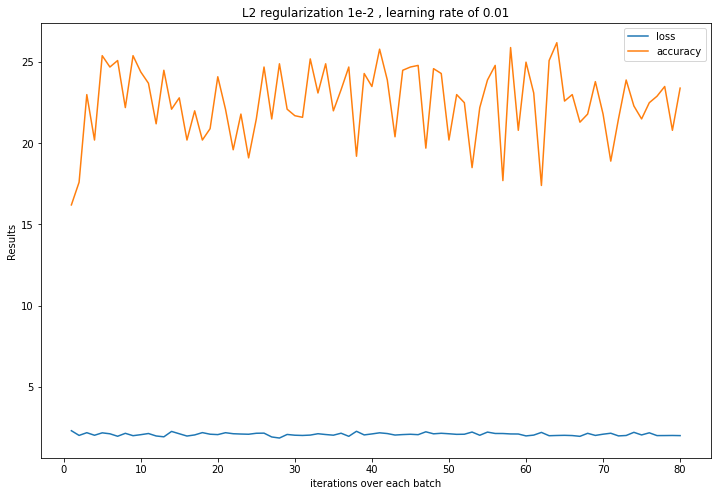

In [49]:
plt.figure()
plt.figure(figsize=(12,8))
plt.title('L2 regularization 1e-2 , learning rate of {}'.format(learning_rate))
plt.plot(results[2],results[0],label='loss')
plt.plot(results[2],results[1],label='accuracy')
#plt.plot(epoch_arr,results[0],label='Train Acurracy')
#plt.plot(epoch_arr,accuracy_test_arr,label='Validation Acurracy')
plt.xlabel('iterations over each batch')
plt.ylabel('Results')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

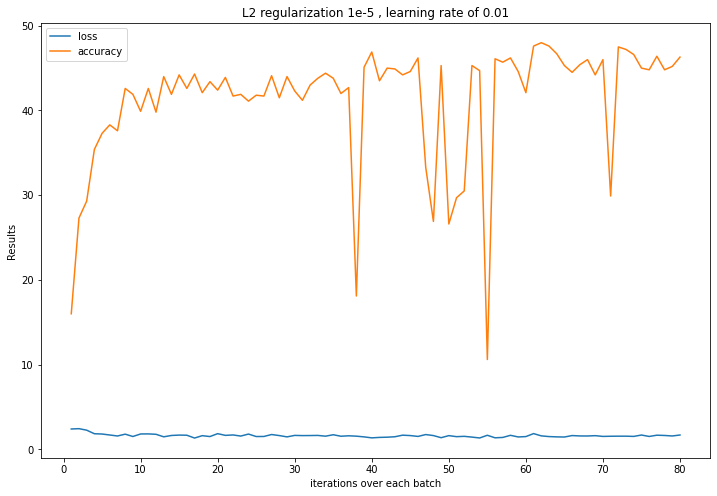

In [43]:
plt.figure()
plt.figure(figsize=(12,8))
plt.title('L2 regularization 1e-5 , learning rate of {}'.format(learning_rate))
plt.plot(results[2],results[0],label='loss')
plt.plot(results[2],results[1],label='accuracy')
#plt.plot(epoch_arr,results[0],label='Train Acurracy')
#plt.plot(epoch_arr,accuracy_test_arr,label='Validation Acurracy')
plt.xlabel('iterations over each batch')
plt.ylabel('Results')
plt.legend()
plt.show()

<B>Results for dropout</B>

Dropout 0.5
> Checking accuracy on validation set
Got 562 / 1000 correct (56.20)
--- 128.14188265800476 seconds ---
Checking accuracy on test set
Got 5261 / 10000 correct (52.61)
None

Dropout 0.2
>Checking accuracy on validation set
Got 541 / 1000 correct (54.10)
--- 129.92907547950745 seconds ---
Checking accuracy on test set
Got 5201 / 10000 correct (52.01)
None

<Figure size 432x288 with 0 Axes>

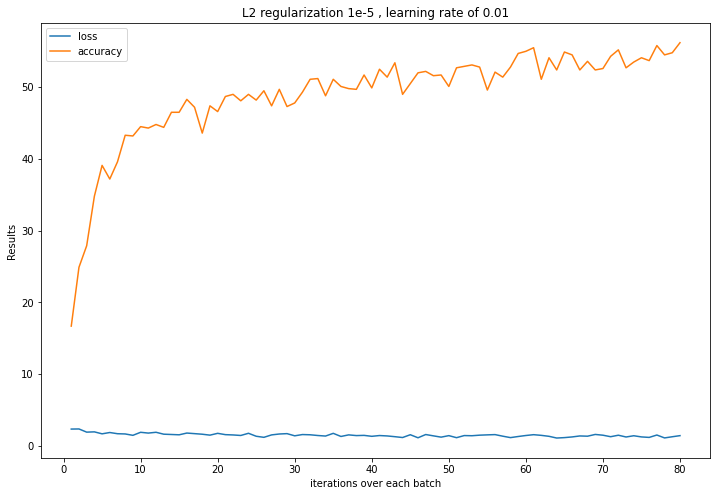

In [45]:
plt.figure()
plt.figure(figsize=(12,8))
plt.title('0.5 regularization , learning rate of {}'.format(learning_rate))
plt.plot(results[2],results[0],label='loss')
plt.plot(results[2],results[1],label='accuracy')
#plt.plot(epoch_arr,results[0],label='Train Acurracy')
#plt.plot(epoch_arr,accuracy_test_arr,label='Validation Acurracy')
plt.xlabel('iterations over each batch')
plt.ylabel('Results')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

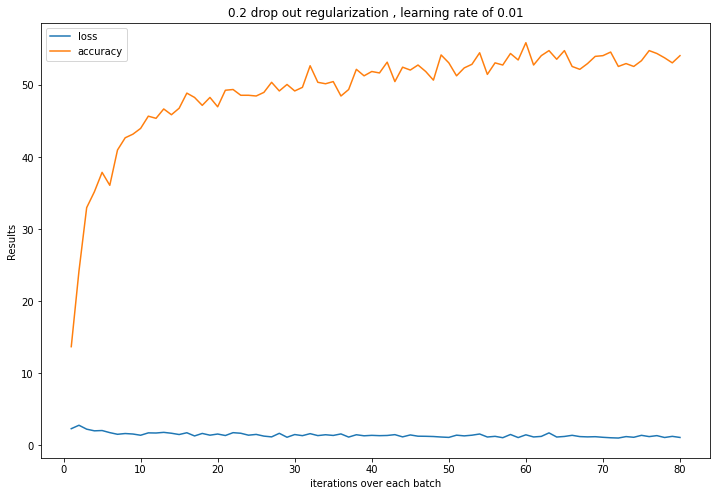

In [52]:
plt.figure()
plt.figure(figsize=(12,8))
plt.title('0.2 drop out regularization , learning rate of {}'.format(learning_rate))
plt.plot(results[2],results[0],label='loss')
plt.plot(results[2],results[1],label='accuracy')
#plt.plot(epoch_arr,results[0],label='Train Acurracy')
#plt.plot(epoch_arr,accuracy_test_arr,label='Validation Acurracy')
plt.xlabel('iterations over each batch')
plt.ylabel('Results')
plt.legend()
plt.show()

<B>Using both methods together</B>

> Checking accuracy on validation set
Got 420 / 1000 correct (42.00)
--- 131.1732804775238 seconds ---
Checking accuracy on test set
Got 3893 / 10000 correct (38.93)
None

In the regularization experiment i used adam L2 regularization and drop out layer in the model. The L2 regularization performed very poorly. Dropout was able to imporve the acuracy in both test and validation sets. Higher number of dropout was able to have the best performance(52.61%)  on the test accuracy over all test data set. Combination of both regularization did not perfromed well. 


## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [54]:
best_model = model
check_accuracy_part34(loader_test, best_model)

Checking accuracy on test set
Got 5187 / 10000 correct (51.87)
